System 1 disregard

[0.29363331 0.0945694  0.61179729]
[0.29377164 0.09454514 0.61168322]
0: 1.0008271606773327: [0.29374778 0.09454931 0.6117029 ]
1: 1.00065810810387: [0.2937244  0.09455341 0.61172218]
2: 1.0004890796934376: [0.29370102 0.09455751 0.61174146]
3: 1.000320057547211: [0.29367764 0.09456161 0.61176074]
4: 1.000151058496755: [0.29365427 0.09456571 0.61178002]
5: 0.9999821132858036: [0.29363089 0.09456982 0.6117993 ]
6: 0.9998132494500517: [0.29360751 0.09457392 0.61181857]
7: 0.9996442298766127: [0.29358413 0.09457802 0.61183785]
8: 0.9994753176157543: [0.29356075 0.09458212 0.61185713]
9: 0.9993064236359275: [0.29353737 0.09458622 0.6118764 ]
10: 0.9991375424611458: [0.293514   0.09459032 0.61189568]
11: 0.9989686898093262: [0.29349062 0.09459443 0.61191495]
12: 0.9987998648589655: [0.29346724 0.09459853 0.61193423]
13: 0.9986310485925312: [0.29344387 0.09460263 0.6119535 ]
14: 0.9984622495836994: [0.29342049 0.09460673 0.61197277]
15: 0.9982934934569839: [0.29339711 0.09461084 0.61199205]


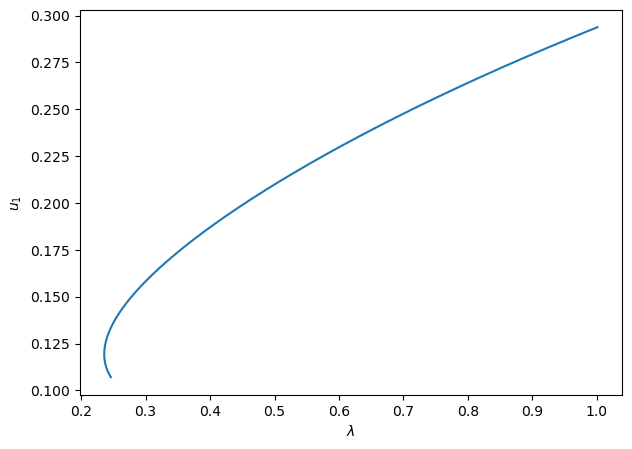

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

zF = np.array([0.25, 0.35, 0.4])
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
xD = np.array([0.89, 0.05, 0.06]) 
xB = np.array([0.01, 0.40,0.59])
R = 3
Fr = 2.5
distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_r(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = 0.001
lam_m1 = 1
# lam_m1 = 0.24949043063463833
old_sol_m1 = root(eqns, x0=np.array([0.29353219, 0.09458548, 0.61188003]), args=(lam_m1,), method=method)
# old_sol_m1 = root(eqns, x0=np.array([0.10467499, 0.16132007, 0.73400479]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(6846):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds * 10
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol1 = u1_sol
l_sol1 = l_sol

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

[0.05846766 0.29134468 0.65018767]
[0.05846625 0.29135741 0.65017634]
0: 1.0000865966810175: [0.05846601 0.29135485 0.65017913]
1: 1.0000615625300193: [0.05846648 0.29135158 0.65018191]
2: 1.0000366466418424: [0.05846695 0.29134833 0.6501847 ]
3: 1.0000117274382876: [0.05846742 0.29134507 0.65018748]
4: 0.9999868118113777: [0.05846789 0.29134182 0.65019027]
5: 0.9999618939765751: [0.05846836 0.29133857 0.65019305]
6: 0.9999369773344836: [0.05846883 0.29133531 0.65019584]
7: 0.9999120615610603: [0.0584693  0.29133206 0.65019862]
8: 0.9998871493128771: [0.05846977 0.2913288  0.65020141]
9: 0.999862232246469: [0.05847023 0.29132555 0.65020419]
10: 0.999837318456592: [0.0584707  0.2913223  0.65020698]
11: 0.99981240366373: [0.05847117 0.29131904 0.65020976]
12: 0.9997874918451966: [0.05847164 0.29131579 0.65021255]
13: 0.9997625797192633: [0.05847211 0.29131253 0.65021533]
14: 0.9997376680689233: [0.05847258 0.29130928 0.65021812]
15: 0.9997127570739287: [0.05847305 0.29130603 0.6502209 ]


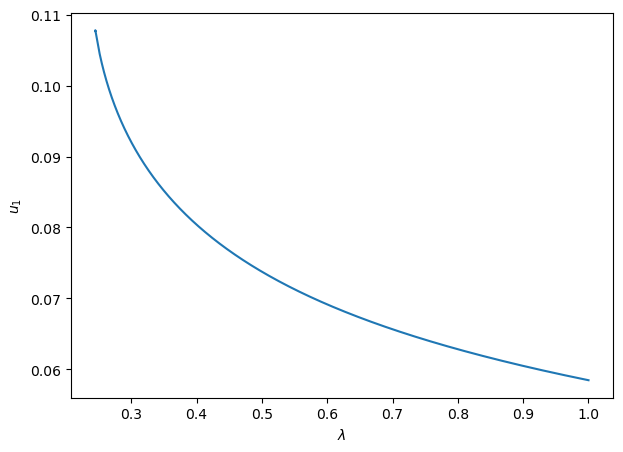

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

zF = np.array([0.25, 0.35, 0.4])
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
xD = np.array([0.89, 0.05, 0.06]) 
xB = np.array([0.01, 0.40,0.59])
R = 3
Fr = 2.5
distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_r(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = 0.0001
lam_m1 = 1
# lam_m1 = 0.24949043063463833
old_sol_m1 = root(eqns, x0=np.array([0.10703618, 0.159142, 0.73382182]), args=(lam_m1,), method=method)
# old_sol_m1 = root(eqns, x0=np.array([0.10467499, 0.16132007, 0.73400479]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(38000):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds * 100
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol2 = u1_sol
l_sol2 = l_sol

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

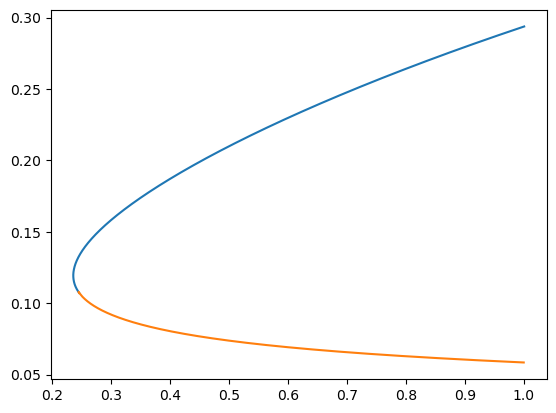

In [6]:
plt.plot(l_sol1, u1_sol1)
plt.plot(l_sol2, u1_sol2)

[0.29363423 0.09456864 0.61179713]
[0.29364713 0.09456698 0.61178588]
0: 1.0000914348517638: [0.29364686 0.0945653  0.61178782]
1: 1.000074428235831: [0.29364451 0.09456571 0.61178975]
2: 1.0000574780640477: [0.29364217 0.09456612 0.61179169]
3: 1.0000405468226807: [0.29363983 0.09456653 0.61179362]
4: 1.0000236099500122: [0.29363748 0.09456695 0.61179555]
5: 1.0000066663984388: [0.29363514 0.09456736 0.61179748]
6: 0.9999897230424442: [0.29363279 0.09456777 0.61179942]
7: 0.999972782050613: [0.29363045 0.09456818 0.61180135]
8: 0.9999558421467736: [0.29362811 0.09456859 0.61180328]
9: 0.9999389027913457: [0.29362576 0.094569   0.61180522]
10: 0.9999219635064098: [0.29362342 0.09456941 0.61180715]
11: 0.9999050213464918: [0.29362107 0.09456982 0.61180908]
12: 0.9998880833149203: [0.29361873 0.09457023 0.61181101]
13: 0.99987114308116: [0.29361639 0.09457065 0.61181295]
14: 0.9998542045125213: [0.29361404 0.09457106 0.61181488]
15: 0.9998372650876423: [0.2936117  0.09457147 0.61181681]


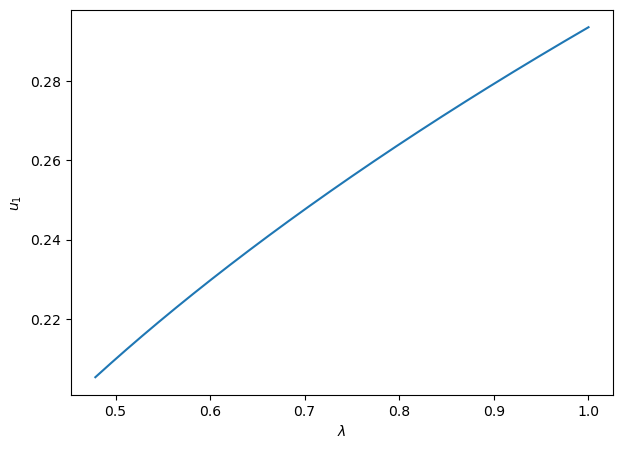

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

zF = np.array([0.25, 0.35, 0.4])
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
xD = np.array([0.89, 0.05, 0.06]) 
xB = np.array([0.01, 0.40,0.59])
R = 3
Fr = 2.5 
distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_r(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = 0.0001
lam_m1 = 1
# lam_m1 = 0.24949043063463833
old_sol_m1 = root(eqns, x0=np.array([0.2, 0.3, 0.4]), args=(lam_m1,), method=method)
# old_sol_m1 = root(eqns, x0=np.array([0.10467499, 0.16132007, 0.73400479]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(38000):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds * 100
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol3 = u1_sol
l_sol3 = l_sol

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

In [1]:
# Fr = 1 (acetone methanol water)
# parameters in demo 3 example 5
# Fr = 0.1 (ethanol water ethylene glycol)
# parameters in demo 3 example 5
# R = 1.35 and continuing on Fr (acetone methanol water)
# parameters in demo 4 example 5
# R = 6 and continuing on Fr (ethanol water ethylene glycol)
# parameters in demo 4 example 5

System 2:
Fr = 1 (acetone methanol water)
parameters in demo 3 example 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

Fr = 1.0
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
xD = np.array([0.93, 0.04, 0.03]) 
D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

R = 3

distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_r(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = 0.001
lam_m1 = 2.5
old_sol_m1 = root(eqns, x0=np.array([0.2, 0.4, 0.4]), args=(lam_m1,), method=method)
# old_sol_m1 = root(eqns, x0=np.array([0.10467499, 0.16132007, 0.73400479]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

for i in range(1000):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds * 100
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol3 = u1_sol
l_sol3 = l_sol

# np.save('results/system2_32-0.593.npy', np.array([u1_sol, u2_sol, u3_sol, l_sol]))

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

[0.08614475 0.4506932  0.46316205]
[0.08612961 0.4507923  0.46307809]
0: 2.500999843078653: [0.08612961 0.45079229 0.46320279]
1: 2.4051025999922633: [0.08760568 0.44113506 0.47125927]
2: 2.4040892785394328: [0.0876215  0.44103129 0.47134721]
3: 2.3767425062763397: [0.08804987 0.43822009 0.47373004]
4: 2.37346438859698: [0.08810142 0.43788159 0.47401691]
5: 2.357959928015172: [0.08834553 0.43627892 0.47537512]
6: 2.3526992167952296: [0.08842921 0.43572793 0.47584272]
7: 2.341350005122107: [0.08860899 0.43454629 0.47684436]
8: 2.3347417127895276: [0.08871424 0.4338535  0.47743205]
9: 2.325211190348808: [0.08886604 0.43285488 0.47827876]
10: 2.3178608074781923: [0.08898356 0.43208113 0.47893506]
11: 2.3092049239550123: [0.08912213 0.43116876 0.47970879]
12: 2.301529174775928: [0.08924538 0.43035683 0.48039751]
13: 2.2933255842552476: [0.08937736 0.42948726 0.48113506]
14: 2.2855603331992462: [0.08950261 0.42866166 0.48183541]
15: 2.2776161810617035: [0.08963102 0.42781503 0.48255362]
16:

In [2]:
np.save('results/system2_2.5-0.586.npy', np.array([u1_sol, u2_sol, u3_sol, l_sol]))


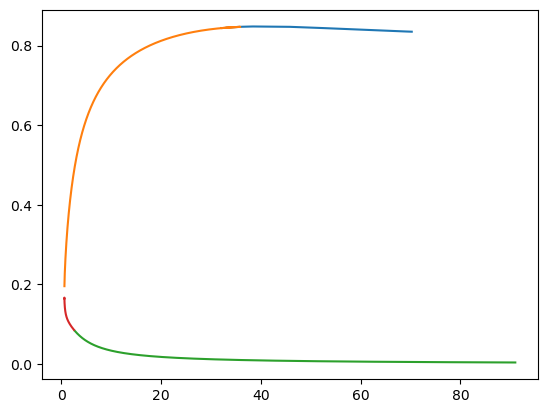

In [4]:
import numpy as np
import matplotlib.pyplot as plt

m1 = np.load('results/system2_33-70.npy')
m2 = np.load('results/system2_32-0.593.npy')
m3 = np.load('results/system2_2.6-91.npy')
m4 = np.load('results/system2_2.5-0.586.npy')


plt.plot(m1[3], m1[0])
plt.plot(m2[3], m2[0])
plt.plot(m3[3], m3[0])
plt.plot(m4[3], m4[0])

System 3:
Fr = 0.1 (ethanol water ethylene glycol)
parameters in demo 3 example 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

A_ij_EWEG = {
    (1,1):0,
    (1,2):615.9,
    (1,3):277.3,
    (2,1):314,
    (2,2):0,
    (2,3):376.028,
    (3,1):892.7,
    (3,2):622.539,
    (3,3):0
}
Eth_A = 23.5807; Eth_B = 3673.81; Eth_C = -46.681
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343
EG_A = 25.1431; EG_B = 6022.18; EG_C = -28.25

EthanolAntoine = AE.AntoineEquationBaseE(Eth_A, Eth_B, Eth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A, Water_B, Water_C)
EthyleneGlycolAntoine = AE.AntoineEquationBaseE(EG_A, EG_B, EG_C)
        
P_sys = 101325
# Create a Raoult's law object
EthWaterEGSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij_EWEG, comp_names = ["Ethanol","Water","Ethylene Glycol"], partial_pressure_eqs = [EthanolAntoine, WaterAntoine, EthyleneGlycolAntoine])

Fr = 0.1
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
xD = np.array([0.93, 0.04, 0.03]) 
D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

R = 3

distillation_model = DistillationModelDoubleFeed(EthWaterEGSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_r(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = -0.01
lam_m1 = 1.25
old_sol_m1 = root(eqns, x0=np.array([0.2, 0.3, 0.4]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(3000):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = abs(ds * 100)
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol3 = u1_sol
l_sol3 = l_sol

ax.plot(l_sol, u2_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

[0.39818322 0.47781669 0.12400008]
[0.36658956 0.50859739 0.12481305]
0: 1.4097477374668383: [0.57385865 0.3133813  0.11276005]
1: 1.388889307705631: [0.55847667 0.32742587 0.11409745]
2: 1.5875255067359701: [0.83432337 0.0621753  0.10350133]
3: 1.5367351210575297: [0.83427208 0.05940609 0.10632182]
4: 1.724433355757305: [0.83073971 0.07268219 0.0965781 ]
5: 1.6710063983543255: [0.83275356 0.06807395 0.09917249]
6: 1.8498025162981024: [0.80429028 0.10486499 0.09084473]
7: 1.8010681478068906: [0.82353051 0.08341538 0.09305411]
8: 2.0026528107967527: [0.82120361 0.09417049 0.08462422]
9: 1.9529873566004359: [0.81870618 0.09447914 0.08681463]
Current Run from convert_x_to_y: 1000
Current Run from convert_x_to_y: 2000
Current Run from convert_x_to_y: 3000
Current Run from convert_x_to_y: 4000
Current Run from convert_x_to_y: 5000
Current Run from convert_x_to_y: 6000
Current Run from convert_x_to_y: 7000
Current Run from convert_x_to_y: 8000
Current Run from convert_x_to_y: 9000
Current Ru

In [2]:
np.save('results/system3.npy', np.array([u1_sol, u2_sol, u3_sol, l_sol]))

System 4
R = 1.35 and continuing on Fr (acetone methanol water)
parameters in demo 4 example 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

R = 1.35
Fr = 1
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
xD = np.array([0.93, 0.04, 0.03]) 
D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

distillation_model = DistillationModelDoubleFeed(AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_fr(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = -0.0005
lam_m1 = 0.8
# lam_m1 = 0.24949043063463833
old_sol_m1 = root(eqns, x0=np.array([0.3, 0.4, 0.3]), args=(lam_m1,), method=method)
# old_sol_m1 = root(eqns, x0=np.array([0.10467499, 0.16132007, 0.73400479]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(3000):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds * 100
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol3 = u1_sol
l_sol3 = l_sol

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

[0.38160167 0.08187466 0.53652367]
[0.38165156 0.08186785 0.53648059]
0: 0.8001450303098457: [0.38158393 0.08187843 0.5365363 ]
1: 0.8007799241781445: [0.38151683 0.0818915  0.53659038]
2: 0.8014162790775614: [0.38144965 0.08190459 0.53664446]
3: 0.8020533814901005: [0.38138249 0.08191768 0.53669853]
4: 0.8026911799101232: [0.38131534 0.08193076 0.5367526 ]
5: 0.803329701519798: [0.3812482  0.08194384 0.53680666]
6: 0.8039689664960237: [0.38118108 0.08195691 0.53686071]
7: 0.804608917307892: [0.38111396 0.08196998 0.53691476]
8: 0.8052496152150753: [0.38104686 0.08198305 0.53696879]
9: 0.8058910404768522: [0.38097977 0.0819961  0.53702283]
10: 0.8065331922999586: [0.38091269 0.08200916 0.53707685]
11: 0.8071760990053222: [0.38084563 0.0820222  0.53713087]
12: 0.8078196714356493: [0.38077857 0.08203524 0.53718488]
13: 0.8084640452924837: [0.38071153 0.08204828 0.53723888]
14: 0.8091091293893519: [0.3806445  0.08206131 0.53729288]
15: 0.8097549459127836: [0.38057749 0.08207434 0.53734687

In [3]:
np.save('results/system4_2-15.npy', np.array([u1_sol, u2_sol, u3_sol, l_sol]))

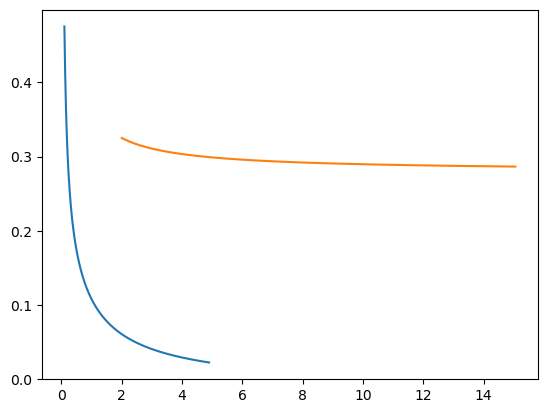

In [4]:
import numpy as np
import matplotlib.pyplot as plt

m1 = np.load('results/system4_0.1-4.89.npy')
m2 = np.load('results/system4_2-15.npy')


plt.plot(m1[3], m1[0])
plt.plot(m2[3], m2[0])

System 5
R = 6 and continuing on Fr (ethanol water ethylene glycol)
parameters in demo 4 example 5

[0.01298208 0.75435303 0.2326644 ]
[0.01298072 0.75435004 0.23266924]
0: 2.000042669160683: [0.01298094 0.75435175 0.23266731]
1: 1.9999858537032449: [0.01298115 0.75435345 0.2326654 ]
2: 1.9999290393759737: [0.01298136 0.75435514 0.23266349]
3: 1.999872227334344: [0.01298158 0.75435684 0.23266158]
4: 1.99981541829348: [0.01298179 0.75435854 0.23265967]
5: 1.9997586119462356: [0.01298201 0.75436023 0.23265776]
6: 1.9997018085296818: [0.01298222 0.75436193 0.23265585]
7: 1.9996450071152323: [0.01298244 0.75436363 0.23265394]
8: 1.9995882087128252: [0.01298265 0.75436532 0.23265203]
9: 1.9995314129813064: [0.01298286 0.75436702 0.23265012]
10: 1.9994746199219504: [0.01298308 0.75436871 0.23264821]
11: 1.9994178297582037: [0.01298329 0.75437041 0.2326463 ]
12: 1.9993610418911028: [0.01298351 0.75437211 0.23264438]
13: 1.9993042568324448: [0.01298372 0.7543738  0.23264247]
14: 1.9992474744866435: [0.01298394 0.7543755  0.23264056]
15: 1.9991906947628564: [0.01298415 0.7543772  0.23263865]


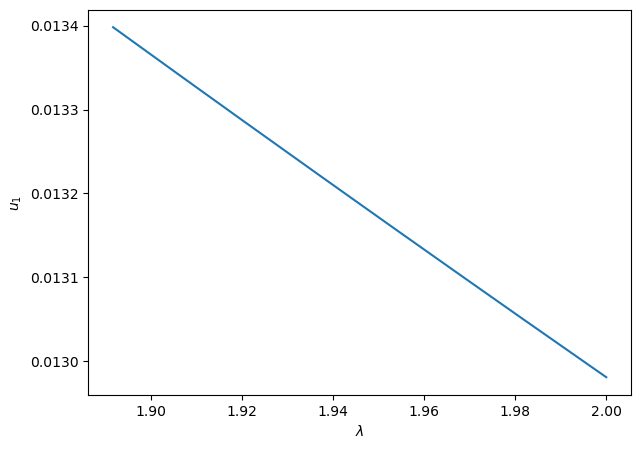

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *
from scipy.optimize import fsolve, root
import math

A_ij_EWEG = {
    (1,1):0,
    (1,2):615.9,
    (1,3):277.3,
    (2,1):314,
    (2,2):0,
    (2,3):376.028,
    (3,1):892.7,
    (3,2):622.539,
    (3,3):0
}
Eth_A = 23.5807; Eth_B = 3673.81; Eth_C = -46.681
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343
EG_A = 25.1431; EG_B = 6022.18; EG_C = -28.25

EthanolAntoine = AE.AntoineEquationBaseE(Eth_A, Eth_B, Eth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A, Water_B, Water_C)
EthyleneGlycolAntoine = AE.AntoineEquationBaseE(EG_A, EG_B, EG_C)
        
P_sys = 101325
# Create a Raoult's law object
EthWaterEGSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij_EWEG, comp_names = ["Ethanol","Water","Ethylene Glycol"], partial_pressure_eqs = [EthanolAntoine, WaterAntoine, EthyleneGlycolAntoine])

Fr = 0.1
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
xD = np.array([0.93, 0.04, 0.03]) 
D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

R = 6

distillation_model = DistillationModelDoubleFeed(EthWaterEGSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

def eqns(uvec, l):
    res = np.zeros(3)

    thermo_sol = distillation_model.thermo_model.convert_x_to_y(uvec)[0]
    middle_sol = distillation_model.change_fr(l).middle_step_x_to_y(uvec)

    res[0] = thermo_sol[0] - middle_sol[0]
    res[1] = thermo_sol[1] - middle_sol[1]
    res[2] = thermo_sol[2] - middle_sol[2]

    return res

def eqns_aug(uvec, tau, ds, u0):
    l         = uvec[-1]
    res       = np.zeros_like(uvec)
    res[0:-1] = eqns(uvec[:-1], l)
    res[-1]   = sum([(uvec[i] - u0[i])*tau[i] for i in range(4)]) - ds

    return res

method = 'krylov'
ds = 0.0001
lam_m1 = 2
old_sol_m1 = root(eqns, x0=np.array([0.2, 0.3, 0.4]), args=(lam_m1,), method=method)
old_sol_m1 = old_sol_m1['x']
print(old_sol_m1)
lam_0 = lam_m1 + ds
old_sol = root(eqns, x0=old_sol_m1, args=(lam_0,), method=method)
old_sol = old_sol['x']
print(old_sol)

u1_sol = []
u2_sol = []
u3_sol = []
l_sol  = []

# for i in range(500000):
for i in range(2000):
    # Solve for tangent vector
    # del_s       = math.sqrt(np.linalg.norm(lam_0 - lam_m1)**2)
    del_s = ds * 100
    # Approximation from eqn 8 of Laing
    tau       = np.array([ (old_sol[0] - old_sol_m1[0])/del_s, (old_sol[1] - old_sol_m1[1])/del_s, (old_sol[2] - old_sol_m1[1])/del_s, (lam_0 - lam_m1)/del_s  ])

    prev_sol    = np.array([old_sol[0], old_sol[1], old_sol[2], lam_0])
    new_sol     = root(eqns_aug, x0 = prev_sol + ds*tau, args = (tau, ds, prev_sol), method=method)
    new_sol = new_sol['x']
    # Edit the variables that hold the two prior solutions
    lam_m1, lam_0 = lam_0, new_sol[-1]
    old_sol_m1 = np.copy(old_sol)
    old_sol    = np.copy(new_sol[:-1])

    # if abs(lam_m1 - lam_0) > 1:
    #     break

    # Add solutions to a list
    u1_sol.append(old_sol[0])
    u2_sol.append(old_sol[1])
    u3_sol.append(old_sol[2])
    l_sol.append(lam_0)

    print(str(i) + ': ' + str(lam_0) + ': ' + str(old_sol))

fig, ax = plt.subplots( figsize = (7,5))

u1_sol3 = u1_sol
l_sol3 = l_sol

ax.plot(l_sol, u1_sol)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$u_1$')
# plt.tight_layout()

plt.show()

In [3]:
np.save('results/system5_2-0.npy', np.array([u1_sol, u2_sol, u3_sol, l_sol]))